In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/language-translation-englishfrench/eng_-french.csv


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv(os.path.join(dirname, filename),nrows=10000)
english_sentences = data["English words/sentences"].tolist()
french_sentences = data["French words/sentences"].tolist()

In [3]:
english_sentences = [str(sentence) for sentence in english_sentences]
french_sentences = [str(sentence) for sentence in french_sentences]
print(len(english_sentences))
print(len(french_sentences))

10000
10000


# Tokenizer in Natural Language Processing

A tokenizer is a crucial component in natural language processing (NLP) that converts text into sequences of tokens, which are typically words or subwords. These tokens can then be processed by machine learning models.

## How Tokenizers Work

1. **Text to Sequence Conversion**:
   - The tokenizer first reads the text and splits it into individual tokens.
   - Each token is then mapped to a unique integer value based on a vocabulary built from the text.

2. **Padding Sequences**:
   - After tokenizing, sequences of different lengths are padded to ensure uniform length, which is required for batch processing in machine learning models.

3. **Example Code in Python**:

```python
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Sample data
sentences = [
    "I love machine learning.",
    "Tokenization is an important step in NLP."
]

# Initialize the Tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the text data
tokenizer.fit_on_texts(sentences)

# Convert sentences to sequences of integers
sequences = tokenizer.texts_to_sequences(sentences)

# Display the sequences
print("Sequences:", sequences)

# Pad the sequences to ensure uniform length
max_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Display the padded sequences
print("Padded Sequences:", padded_sequences)

Sequences: `[[1, 2, 3, 4], [5, 6, 7, 8, 9, 10, 11]]`  
Padded Sequences: `[[ 1  2  3  4  0  0  0] [ 5  6  7  8  9 10 11]]`


In [4]:
# Tokenize the English sentences
tokenizer_eng = Tokenizer()
tokenizer_eng.fit_on_texts(english_sentences)
eng_seq = tokenizer_eng.texts_to_sequences(english_sentences)

#Tokenize the french Sentences 
tokenizer_fr = Tokenizer()
tokenizer_fr.fit_on_texts(french_sentences)
fr_seq = tokenizer_fr.texts_to_sequences(french_sentences)


vocab_size_eng = len(tokenizer_eng.word_index) + 1
vocab_size_fr = len(tokenizer_fr.word_index) + 1

# applying the padding
max_length = max(len(seq) for seq in eng_seq + fr_seq)
eng_seq_padded = pad_sequences(eng_seq, maxlen=max_length, padding='post')
fr_seq_padded = pad_sequences(fr_seq, maxlen=max_length, padding='post')

# Encoder and Decoder in Sequence-to-Sequence Models

## Encoder

The **encoder** is the first component of a sequence-to-sequence (seq2seq) model. It processes the input sequence and encodes it into a fixed-size context vector, which captures the essential information of the entire input sequence. The encoder typically consists of an embedding layer followed by a recurrent layer, such as LSTM or GRU. As the encoder processes each token in the sequence, it updates its hidden states, and the final hidden state (or a set of states) represents the context vector. This vector is then passed to the decoder.

## Decoder

The **decoder** is the second component of a seq2seq model. It takes the context vector from the encoder and generates the output sequence, typically one token at a time. The decoder is also usually built with an embedding layer and a recurrent layer. At each step, the decoder predicts the next token in the sequence based on the context vector and the previously generated tokens. The process continues until the entire output sequence is generated. The decoder's ability to generate the sequence relies heavily on the information provided by the encoder.


## Embedding Dimension and Units
- **Embedding Dimension**: The embedding layer's output dimension is set to `256`.
- **LSTM Units**: The number of units in the LSTM layer is set to `512`.

## Encoder
- **Encoder Inputs**: 
  - The encoder input is defined with a shape of `(max_length,)`, representing the sequence length.
  - This input is passed through an embedding layer, which converts input sequences into dense vectors of size `256`.
- **Encoder LSTM**:
  - The embedded input is then fed into an LSTM layer with `512` units.
  - The LSTM outputs three components: `encoder_outputs`, `state_h` (hidden state), and `state_c` (cell state).
  - These states (`state_h`, `state_c`) are stored as `encoder_states`, which will be used as the initial state for the decoder.

## Decoder
- **Decoder Inputs**:
  - The decoder input is defined with a shape of `(max_length,)`, similar to the encoder.
  - An embedding layer is created for the decoder with an output dimension of `256`, using the French vocabulary size (`vocab_size_fr`).
- **Decoder LSTM**:
  - The embedded decoder input is fed into an LSTM layer configured to return sequences (`return_sequences=True`) as well as states.
  - The initial states for this LSTM are provided by the `encoder_states` (i.e., `state_h`, `state_c`).
- **Decoder Dense Layer**:
  - The output of the decoder LSTM is passed through a dense layer with a `softmax` activation function, producing a probability distribution over the French vocabulary.

## Model Compilation
- **Model Definition**:
  - The final model is defined by connecting the encoder and decoder, with the encoder input and decoder input as the input to the model, and the decoder output as the model's output.
- **Compilation**:
  - The model is compiled using the `Adam` optimizer and `sparse_categorical_crossentropy` as the loss function.
  - The model also tracks accuracy as a metric during training.


In [5]:
embedding_dim = 256
units = 512

# Encoder
encoder_inputs = Input(shape=(max_length,))
enc_emb = Embedding(input_dim=vocab_size_eng, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_length,))
dec_emb_layer = Embedding(input_dim=vocab_size_fr, output_dim=embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_fr, activation='softmax')
output = decoder_dense(decoder_outputs)

# the model that connects the encoder and decoder
model = Model([encoder_inputs, decoder_inputs], output)

# Compile the model with an appropriate optimizer and loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [6]:
# pip install pydot

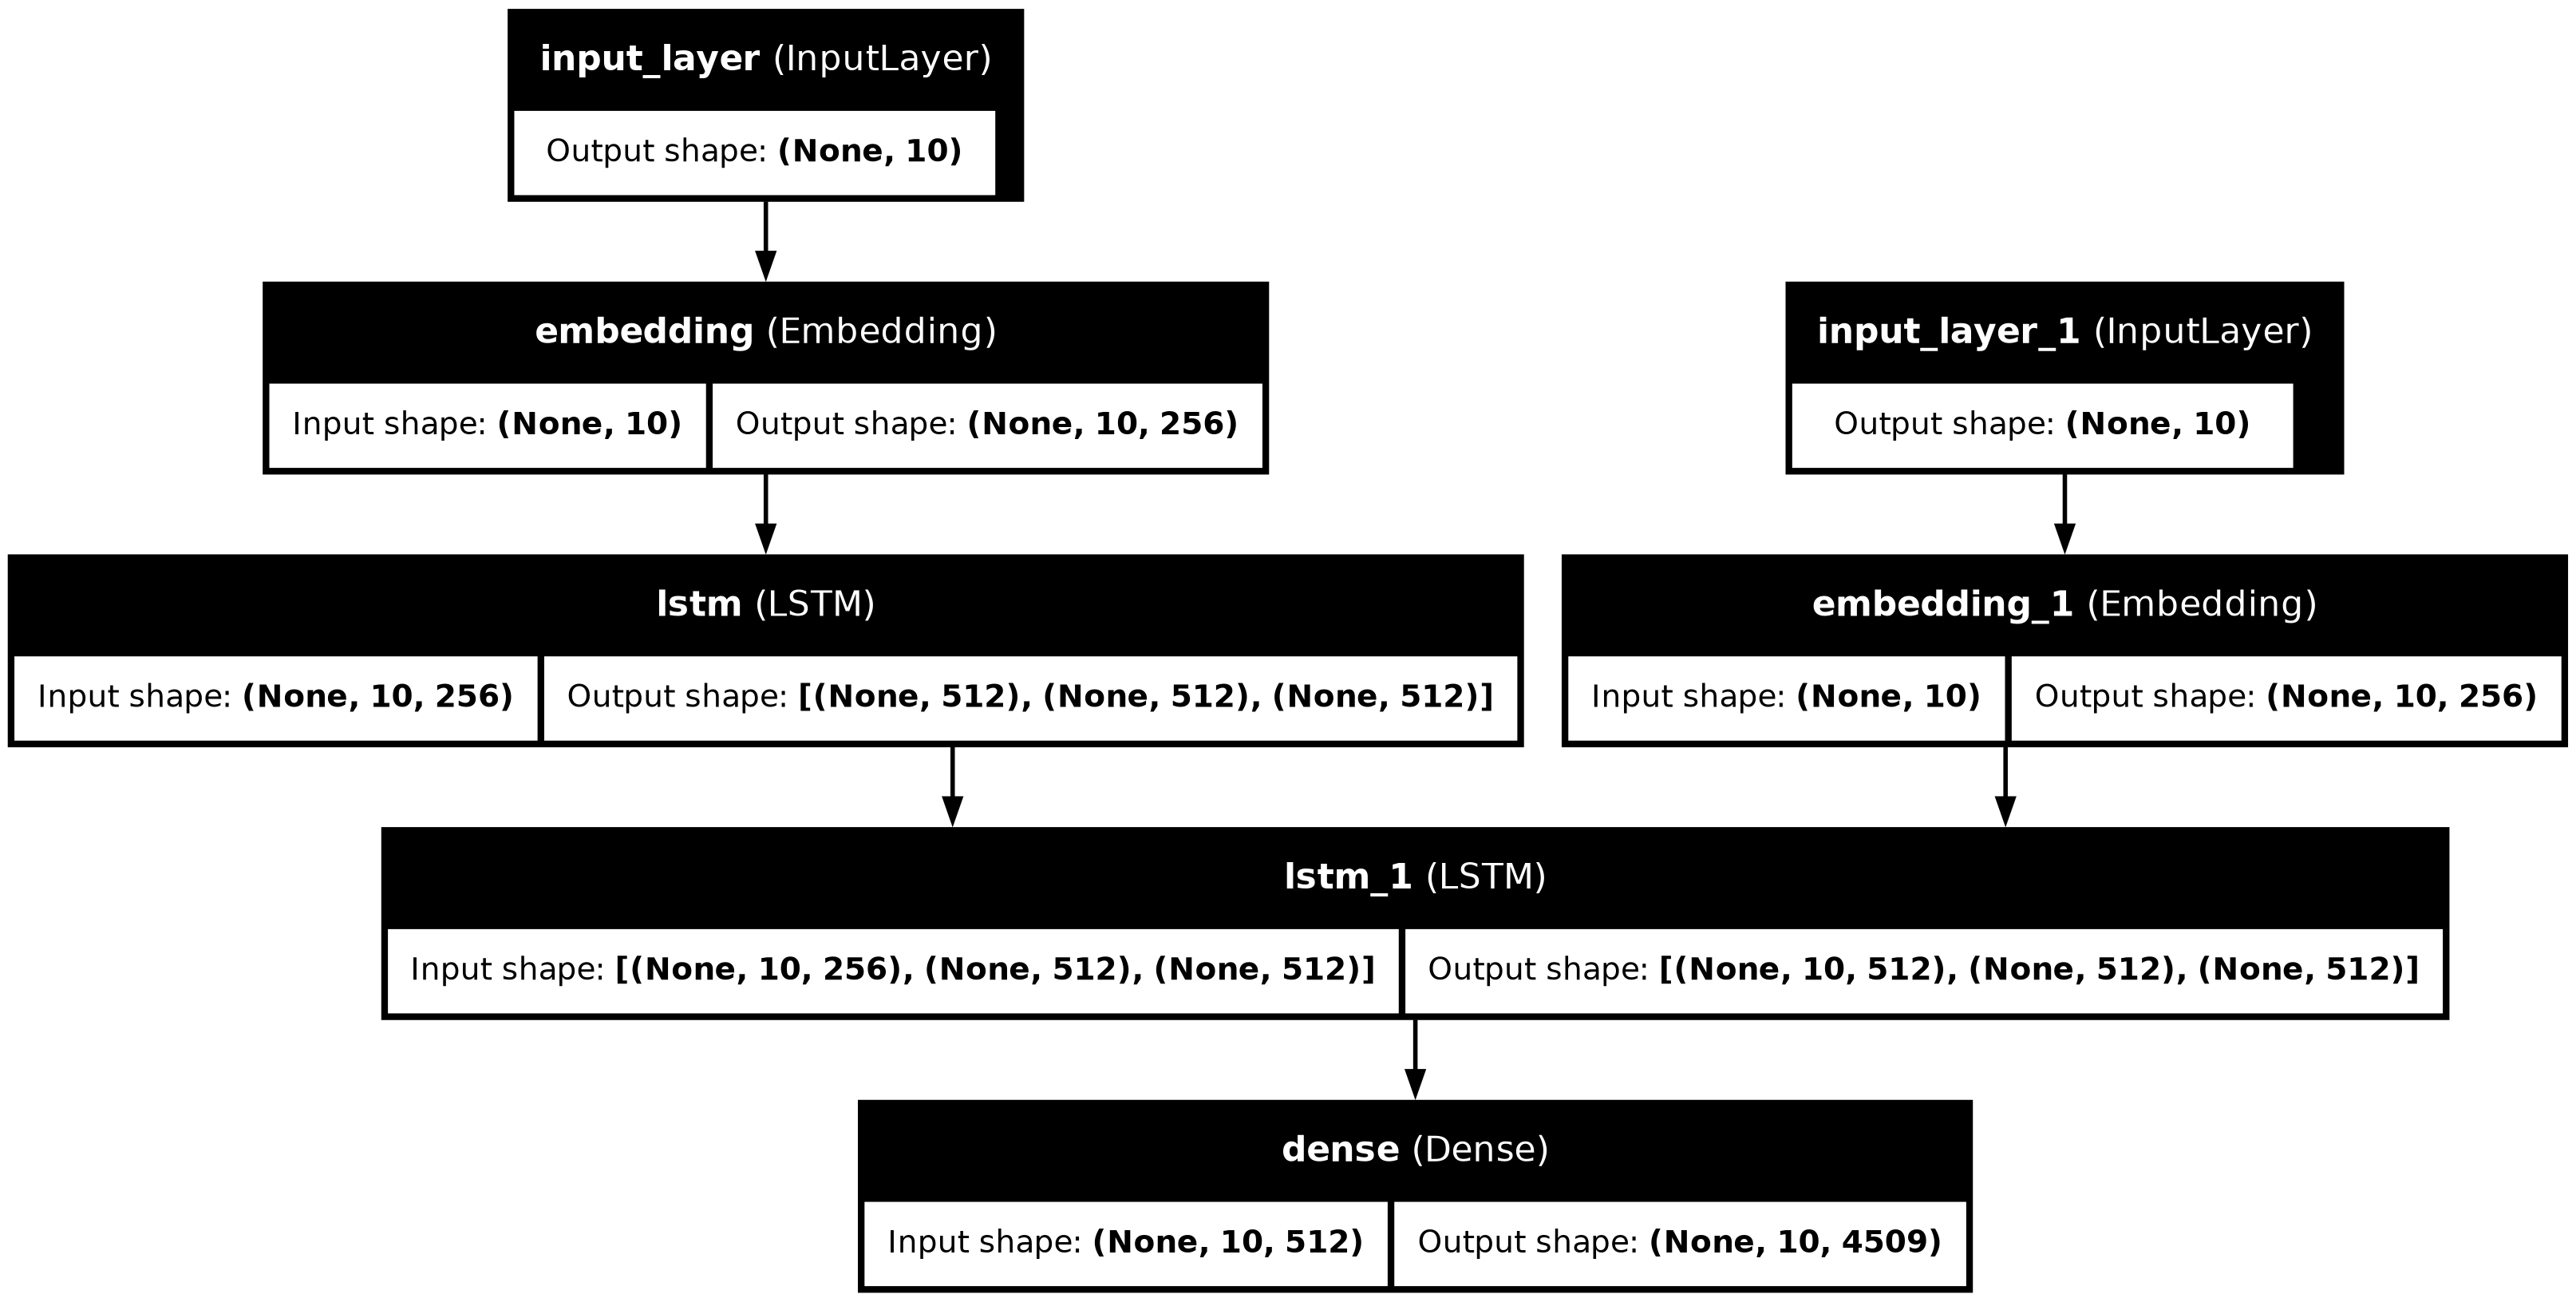

In [7]:

from tensorflow.keras.utils import plot_model

#  model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(eng_seq_padded, fr_seq_padded, test_size=0.1)
history = model.fit([X_train, X_train], y_train, validation_data=([X_val, X_val], y_val), epochs=6, batch_size=64)

Epoch 1/6
141/141 ━━━━━━━━━━━━━━━━━━━━ 123s 844ms/step - accuracy: 0.6464 - loss: 3.3180 - val_accuracy: 0.6902 - val_loss: 2.1605
Epoch 2/6
141/141 ━━━━━━━━━━━━━━━━━━━━ 119s 846ms/step - accuracy: 0.6982 - loss: 2.0432 - val_accuracy: 0.7268 - val_loss: 1.9682
Epoch 3/6
141/141 ━━━━━━━━━━━━━━━━━━━━ 139s 828ms/step - accuracy: 0.7356 - loss: 1.8105 - val_accuracy: 0.7470 - val_loss: 1.8203
Epoch 4/6
141/141 ━━━━━━━━━━━━━━━━━━━━ 116s 826ms/step - accuracy: 0.7490 - loss: 1.6372 - val_accuracy: 0.7574 - val_loss: 1.7305
Epoch 5/6
141/141 ━━━━━━━━━━━━━━━━━━━━ 117s 827ms/step - accuracy: 0.7608 - loss: 1.4854 - val_accuracy: 0.7627 - val_loss: 1.6635
Epoch 6/6
141/141 ━━━━━━━━━━━━━━━━━━━━ 143s 834ms/step - accuracy: 0.7683 - loss: 1.3607 - val_accuracy: 0.7699 - val_loss: 1.6026


In [9]:
loss, accuracy = model.evaluate([X_val, X_val], y_val)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7668 - loss: 1.6153


In [10]:
print("The overall Accuracy: ")
print(accuracy)

The overall Accuracy: 
0.7698999047279358


In [11]:
np.shape(X_train)

(9000, 10)

# Sentence Translation Function

The following Python code defines a function `translate_sentence` that translates an English sentence into French using a trained sequence-to-sequence model. The function leverages a tokenizer to convert the input sentence into sequences of integers, which are then fed into the model to generate a translated sequence.



### Translation Function for Sentence

The following function translates an input sentence from English to French using the trained model.

1. **Sentence Preprocessing**:
   - The input sentence is tokenized using `tokenizer_eng` to convert it into a sequence of integers.
   - The sequence is then padded to match the `max_length` of the sequences used during training.

2. **Model Prediction**:
   - The padded sequence is passed through the trained model to predict the corresponding French sequence.
   - The `np.argmax` function is used to find the index of the maximum probability at each timestep, which corresponds to the predicted word in the French vocabulary.

3. **Translation Construction**:
   - The predicted indices are mapped to words using `tokenizer_fr.index_word`.
   - If the index is found in the tokenizer's word index, the corresponding word is appended to the translated sentence; otherwise, a space is added.

4. **Return Translated Sentence**:
   - The final translated sentence is constructed by joining the list of words.

5. **Example Usage**:
   - The function `translate_sentence` is used to translate the input sentence `"hello where are you"`.
   - The original and translated sentences are printed.



In [12]:
def translate_sentence(sentence):
    seq = tokenizer_eng.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=max_length, padding='post')
    translated = np.argmax(model.predict([padded, padded]), axis=-1)
    
    translated_sentence = []
    for i in translated[0]:
        if i in tokenizer_fr.index_word:
            translated_sentence.append(tokenizer_fr.index_word[i])
        else:
            translated_sentence.append(' ') 
        
    return ' '.join(translated_sentence)

input_sentence = "hello where are you"
translated_sentence = translate_sentence(input_sentence)
print(f"Input: {input_sentence}")
print(f"Translated: {translated_sentence}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
Input: hello where are you
Translated: ferme les une              


In [13]:
# Example translation
input_sentence = "hello where are you"
translated_sentence = translate_sentence(input_sentence)
print(f"Input: {input_sentence}")
print(f"Translated: {translated_sentence}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Input: hello where are you
Translated: ferme les une              


In [14]:
val = "Hello subham kumar where.I really like you. Do you want to marry me. Hello"
list_sen = val.split('.')
print(list_sen)
new_list = []
for i in range(len(list_sen)):
    new_list.append(translate_sentence(list_sen[i]))
for i in range(len(new_list)):
    print(new_list[i])

['Hello subham kumar where', 'I really like you', ' Do you want to marry me', ' Hello']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
prends vous                
j'aime les                
est vous vous              
restez                  


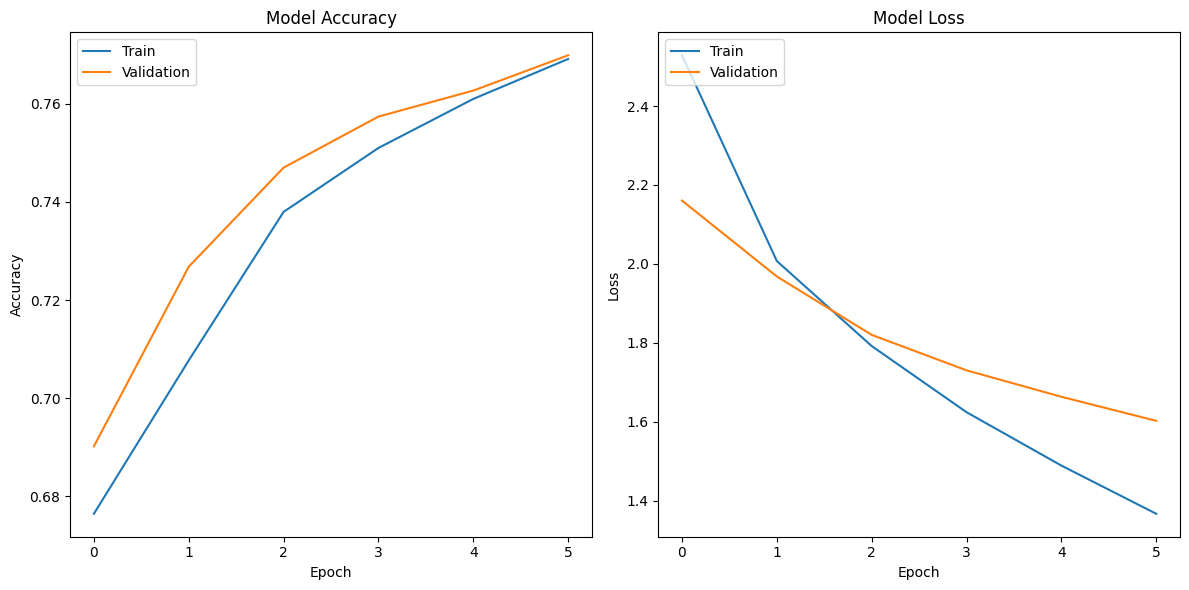

In [15]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.tight_layout()
plt.show()